# Mood Classification Project

## Overview
This notebook builds an End-to-End Image Classification Pipeline using TensorFlow and Keras. 
The goal is to classify images into different mood categories (e.g., Happy vs Sad).

## Steps Covered:
1.  **Setup**: Configure GPU and import libraries.
2.  **Data Cleaning**: Remove images with invalid extensions or corruption.
3.  **Data Loading**: Load dataset using `image_dataset_from_directory`.
4.  **Preprocessing**: Scale image pixel values.
5.  **Model Building**: Create a CNN with Data Augmentation.
6.  **Training**: Train the model and visualize performance.
7.  **Evaluation**: Test the model on unseen data.

### 1. Setup and Imports
We start by importing necessary libraries and configuring TensorFlow to use GPU memory efficiently (to avoid OOM errors).

In [2]:
import os
import cv2
import imghdr
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.list_physical_devices('GPU')
print(f'GPUs available: {len(gpus)}')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f'GPU memory growth error: {e}')

# Print device info for debugging
print(f'Devices: {tf.config.list_physical_devices()}')

C:\Users\3BSALAM\AppData\Local\Temp\ipykernel_26072\431703503.py:3: DeprecationWarning: imghdr was removed in Python 3.13. Please be aware that you are currently NOT using standard 'imghdr', but instead a separately installed 'standard-imghdr'.
  import imghdr
C:\Users\3BSALAM\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


GPUs available: 0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### GPU Status & Important Notes

⚠️ **If GPUs available shows 0:**
TensorFlow-CPU is installed. To use GPU (10-50x faster):
```bash
pip uninstall tensorflow
pip install tensorflow[and-cuda]
```


### 2. Data Cleaning
We iterate through the dataset directory and remove any images that do not have allowed extensions (jpeg, jpg, bmp, png) or are corrupted.

In [3]:
data_dir = 'mood'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path} \n {e}')
            # os.remove(image_path) # Uncomment to delete bad files

### 3. Data Loading
We use Keras `image_dataset_from_directory` to create a dataset iterator. This handles batching, image resizing, and shuffling automatically.

In [4]:
data = tf.keras.utils.image_dataset_from_directory(
    'mood',
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True  # Ensure proper shuffling
)
print(f'Dataset loaded: {len(data)} batches')
print(f'Class names: {data.class_names}')

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(f'Batch shape - Images: {batch[0].shape}, Labels: {batch[1].shape}')

Found 438 files belonging to 2 classes.


Dataset loaded: 14 batches
Class names: ['happy', 'sad']
Batch shape - Images: (32, 256, 256, 3), Labels: (32,)


### 4. Data Visualization
Let's visualize a few images from the batch to make sure the data is loaded correctly.

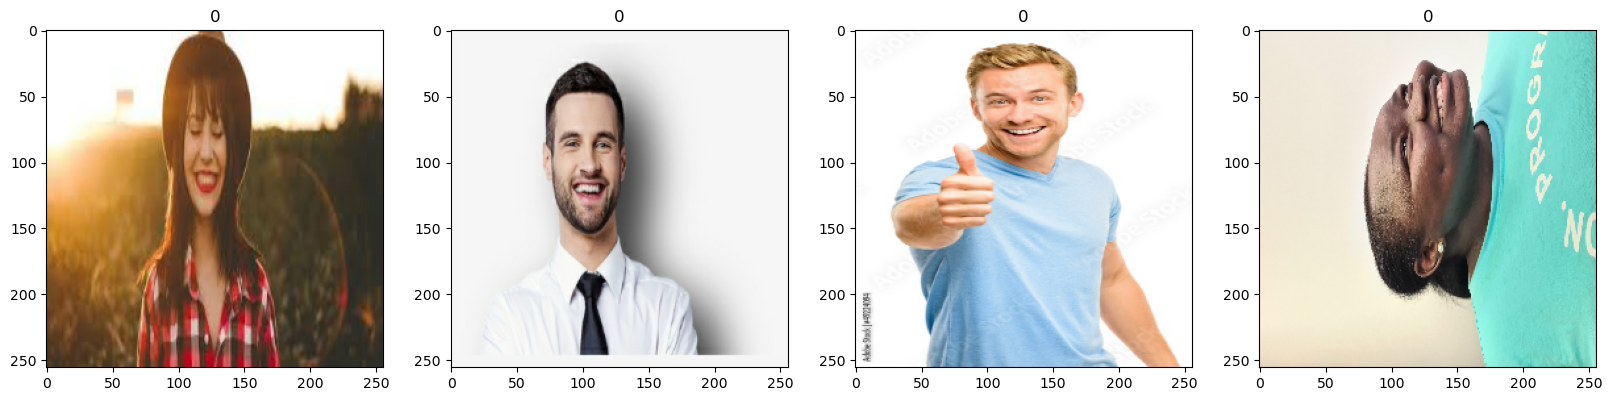

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

### 5. Data Preprocessing
Scale the image pixel values from [0, 255] to [0, 1] for better model convergence.

In [6]:
data = data.map(lambda x, y: (x / 255, y))

### 6. Dataset Splitting
Split the data into Training (70%), Validation (20%), and Testing (10%) sets.

In [7]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### 7. Model Building
We build a Sequential CNN model with critical fixes for binary classification.

**Key Fixes Applied:**
- ✅ **Sigmoid activation** (NOT softmax) for single-unit binary classification
- ✅ **BinaryCrossentropy loss** (NOT CategoricalCrossentropy) - fixes 46% accuracy bug
- ✅ **Data Augmentation** (`RandomFlip`, `RandomRotation(0.2)`, `RandomZoom(0.2)`) prevents overfitting
- ✅ **L2 regularization (0.0001)** - gentler than L1, better convergence
- ✅ **Multiple dense layers** (256→128) - improved feature learning
- ✅ **Dropout layers** - prevents overfitting

In [8]:
model = Sequential([
    # Data Augmentation Layers (moderate - not too aggressive)
    RandomFlip("horizontal", input_shape=(256, 256, 3)),
    RandomRotation(0.15),
    RandomZoom(0.15),
    
    # Convolutional Blocks - simpler architecture, less prone to overfitting
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Dense Layers with batch normalization
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    Dropout(0.3),
    
    # Output Layer: Sigmoid for Binary Classification
    Dense(1, activation='sigmoid')
])

# Compile with BinaryCrossentropy for binary classification
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate for stability
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy', Precision(), Recall()]
)
model.summary()

C:\Users\3BSALAM\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,560,737 (257.72 MB)

 Trainable params: 67,560,737 (257.72 MB)

 Non-trainable params: 0 (0.00 B)

### 8. Training
Train the model for 30 epochs (with EarlyStopping) using TensorBoard for logging.
- **Epochs**: 30 (increased from 20)
- **EarlyStopping**: patience=5 on val_loss to prevent overfitting
- **Metrics**: Tracks Precision and Recall in addition to Accuracy

In [9]:
logdir = 'm_logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Class weights to handle imbalance (226 sad / 214 happy = 1.056)
# Weight for happy (0) should be higher to balance out slightly more sad images
class_weights = {0: 1.1, 1: 0.9}

print('\nStarting training with class weights...')
hist = model.fit(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stop],
    class_weight=class_weights,
    verbose=1
)


Starting training with class weights...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.4757 - loss: 0.9113 - precision: 0.5000 - recall: 0.4437 - val_accuracy: 0.4688 - val_loss: 0.8809 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5104 - loss: 0.8741 - precision: 0.6000 - recall: 0.1027 - val_accuracy: 0.4792 - val_loss: 0.8746 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.4826 - loss: 0.8663 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.8629 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5417 - loss: 0.8580 - precision: 0.7500 - recall: 0.0857 - val_accuracy: 0.4688 - val_loss: 0.8642 - val_precision: 1.0000 - val_recall: 0.0192
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5000 - loss: 0.8484 - precision: 0.8333 -

### 9. Evaluation
Plotting Loss and Accuracy curves to check for overfitting/underfitting.

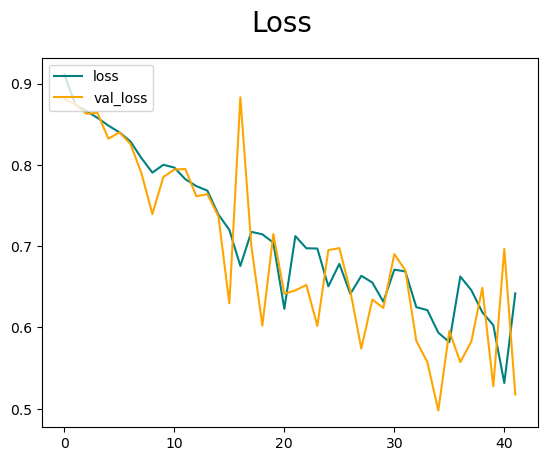

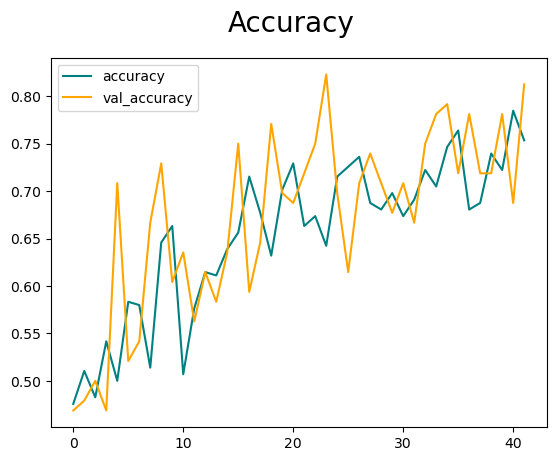

In [10]:
# Loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 10. Testing
Evaluate the model on the held-out Test set using Precision, Recall, and Binary Accuracy.

In [11]:
print('\nEvaluating on test set...')
test_results = model.evaluate(test, verbose=0)
test_loss, test_acc = test_results[0], test_results[1]

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X, verbose=0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"\n=== Test Set Results ===")
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")
print(f"Loss: {test_loss:.4f}")


Evaluating on test set...

=== Test Set Results ===
Precision: 0.8571
Recall: 0.8000
Accuracy: 0.8148
Loss: 0.5330


### 11. Saving
Save the trained model.

In [12]:
if not os.path.exists('models'):
    os.makedirs('models')
model.save(os.path.join('models', 'mood.h5'))